In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
data = pd.read_csv('heart.csv')

In [3]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Exploratory Data Analysis

In [4]:
num_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
cat_cols = ['Sex', 'ChestPainType','ExerciseAngina', 'ST_Slope']

In [5]:
print("Summary statistics for numerical variables:")
print(data[num_cols].describe())

Summary statistics for numerical variables:
              Age   RestingBP  Cholesterol   FastingBS       MaxHR     Oldpeak
count  918.000000  918.000000   918.000000  918.000000  918.000000  918.000000
mean    53.510893  132.396514   198.799564    0.233115  136.809368    0.887364
std      9.432617   18.514154   109.384145    0.423046   25.460334    1.066570
min     28.000000    0.000000     0.000000    0.000000   60.000000   -2.600000
25%     47.000000  120.000000   173.250000    0.000000  120.000000    0.000000
50%     54.000000  130.000000   223.000000    0.000000  138.000000    0.600000
75%     60.000000  140.000000   267.000000    0.000000  156.000000    1.500000
max     77.000000  200.000000   603.000000    1.000000  202.000000    6.200000


In [6]:
data.astype('object').describe()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918,918,918,918,918,918,918,918,918,918.0,918,918
unique,50,2,4,67,222,2,3,119,2,53.0,3,2
top,54,M,ASY,120,0,0,Normal,150,N,0.0,Flat,1
freq,51,725,496,132,172,704,552,43,547,368.0,460,508


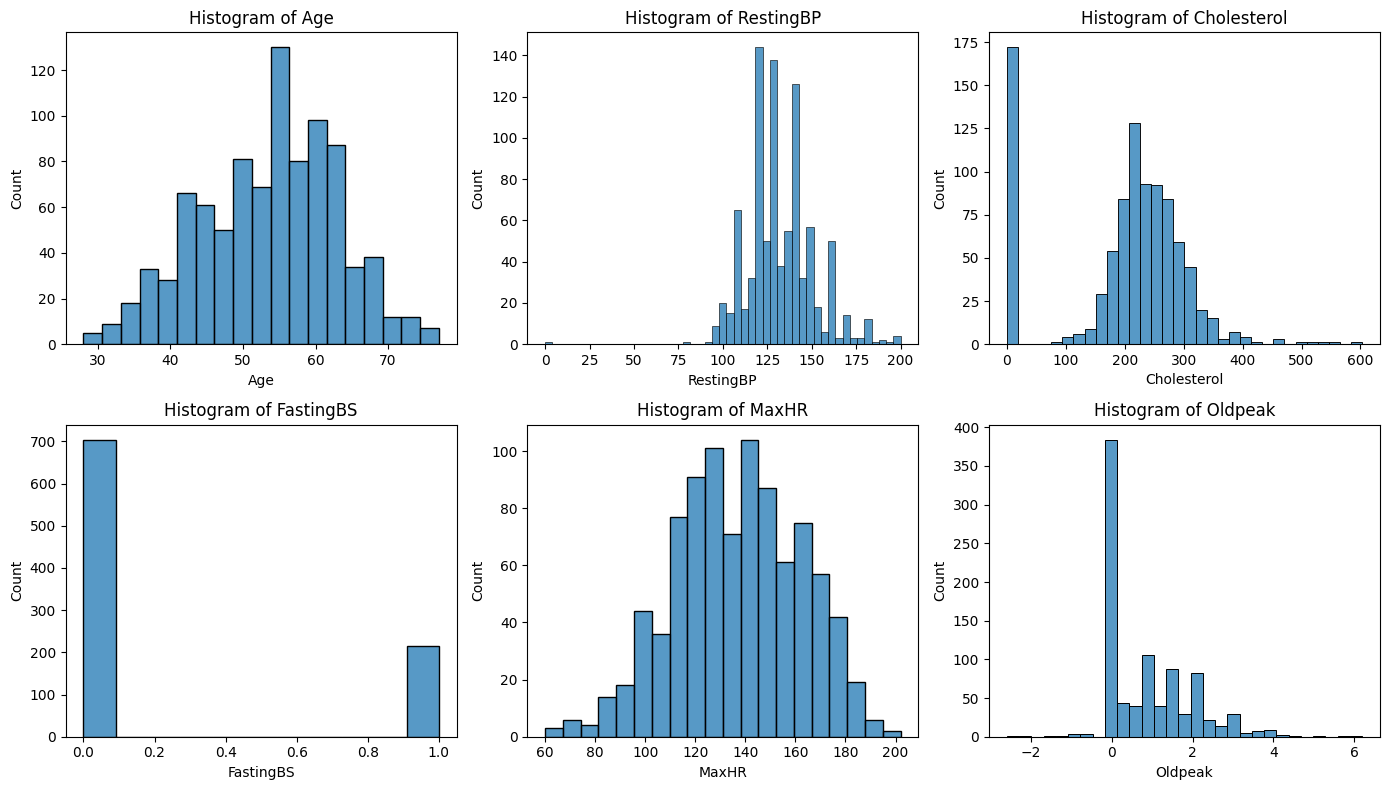

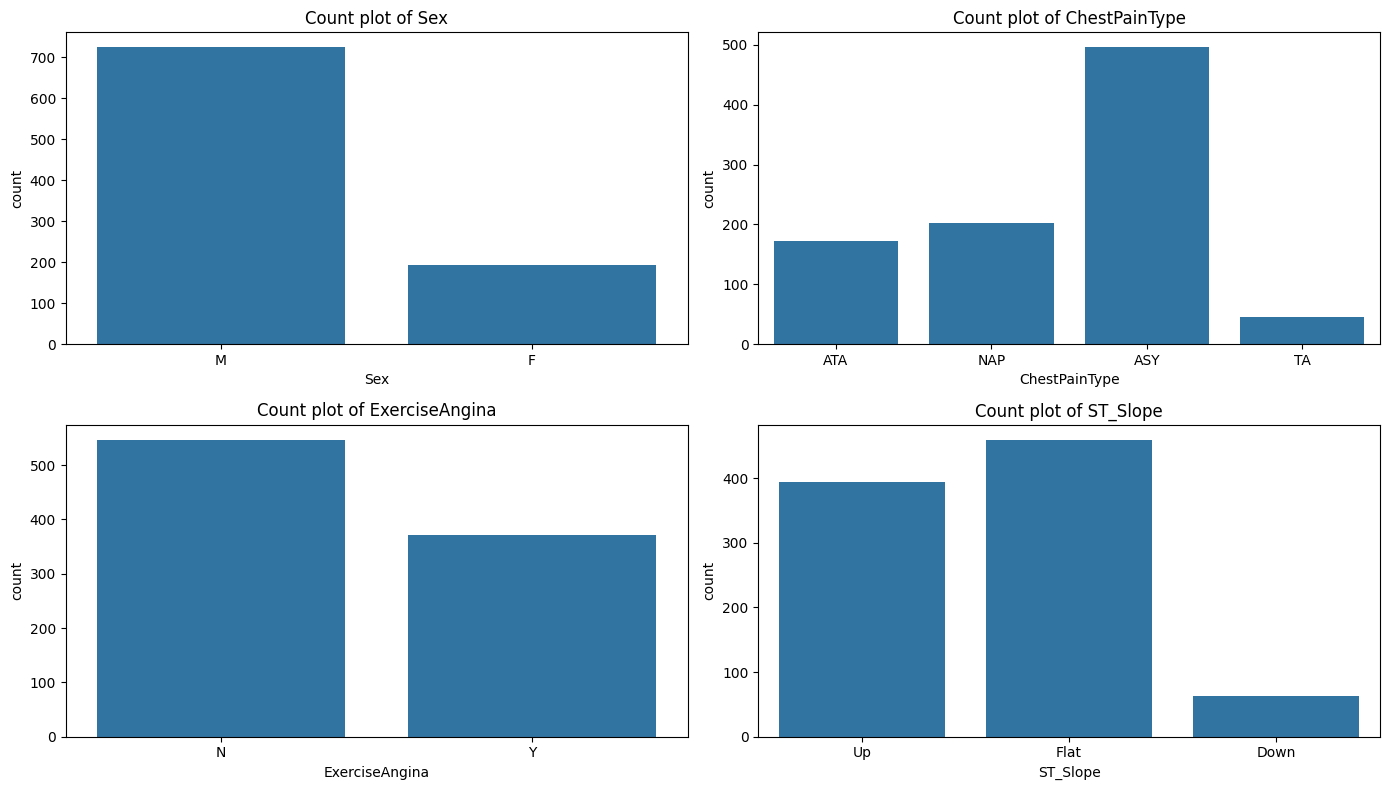

In [7]:
plt.figure(figsize=(14, 8))

for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(data[col])
    plt.title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))

for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=col, data=data)
    plt.title(f'Count plot of {col}')

plt.tight_layout()
plt.show()

### How can cholesterol impact whether a patient develops heart disease or not?

Here, using a logistic regression classifier, I will first create a model to predict incidence of heart disease using only the cholesterol column as a predictor. I will then evaluate the accuracy of this model.

In [8]:
X_chol = data[['Cholesterol']]
y_chol = data['HeartDisease']

X_chol_train, X_chol_test, y_chol_train, y_chol_test = train_test_split(X_chol, y_chol, test_size=0.2, random_state=42)

In [9]:
logistic_model = Pipeline([
    ('scaler', StandardScaler()),  # Scale the data
    ('lr', LogisticRegression())  # Apply Logistic Regression
])
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier()

voting_clf = VotingClassifier(
    estimators=[
        ('lr', logistic_model),
        ('dt', decision_tree_model),
        ('rf', random_forest_model)
    ],
    voting='hard'
)

In [10]:
voting_clf.fit(X_chol_train, y_chol_train)

y_pred = voting_clf.predict(X_chol_test)

accuracy = accuracy_score(y_chol_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)


Voting Classifier Accuracy: 0.5652173913043478


Evidently, when only the cholesterol column is used, the accuracy of this model is low.

### Using other factors (not just cholesterol) to create a model to predict if a patient has heart disease or not.
Here, I will use the other factors available in the dataset (not just cholesterol) to create a model to predict incidence of heart disease. I will then evaluate the accuracy of that model.

In [11]:
X = data.drop(columns='HeartDisease')
y = data['HeartDisease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])


In [13]:
logistic_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

decision_tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [14]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', logistic_pipeline),
        ('dt', decision_tree_pipeline),
        ('rf', random_forest_pipeline)
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Voting Classifier Accuracy:", accuracy)

Voting Classifier Accuracy: 0.8804347826086957


The accuracy of this model is significantly higher than the model where only cholesterol was used. This thereby demonstrates how cholesterol alone cannot predict incidence of heart disease.

### Visualizations

In [15]:
### Creating a bar graph split by cholesterol levels
bins = [0, 200, 240, 300, np.inf]
labels = ['Low (<200)', 'Borderline (200-240)', 'High (240-300)', 'Very High (>300)']
data['Cholesterol_Category'] = pd.cut(data['Cholesterol'], bins=bins, labels=labels)

category_stats = data.groupby('Cholesterol_Category')['HeartDisease'].agg(['mean', 'std', 'count']).reset_index()
category_stats['std_error'] = category_stats['std'] / np.sqrt(category_stats['count'])  # Calculate standard error

print(category_stats)

   Cholesterol_Category      mean       std  count  std_error
0            Low (<200)  0.393333  0.490126    150   0.040019
1  Borderline (200-240)  0.439834  0.497400    241   0.032040
2        High (240-300)  0.539683  0.499415    252   0.031460
3      Very High (>300)  0.533981  0.501283    103   0.049393


/var/folders/fg/6c6fbnns7txcs5w_b8qr1wvm0000gn/T/ipykernel_3081/1715837272.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_stats = data.groupby('Cholesterol_Category')['HeartDisease'].agg(['mean', 'std', 'count']).reset_index()


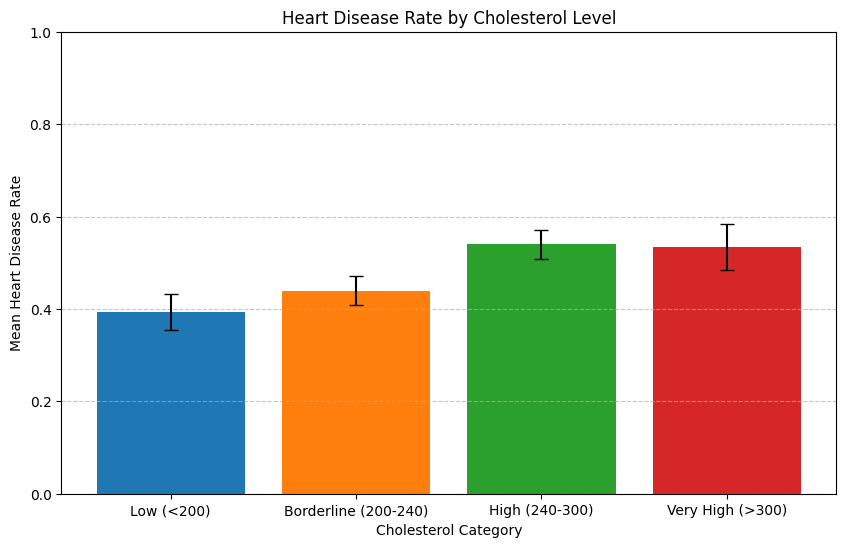

In [16]:
plt.figure(figsize=(10, 6))
plt.bar(
    category_stats['Cholesterol_Category'],
    category_stats['mean'],
    yerr=category_stats['std_error'],
    capsize=5,
    color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
)

plt.xlabel('Cholesterol Category')
plt.ylabel('Mean Heart Disease Rate')
plt.title('Heart Disease Rate by Cholesterol Level')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

This visualization demonstrates how those with higher cholesterol tend to have higher rates of heart disease.

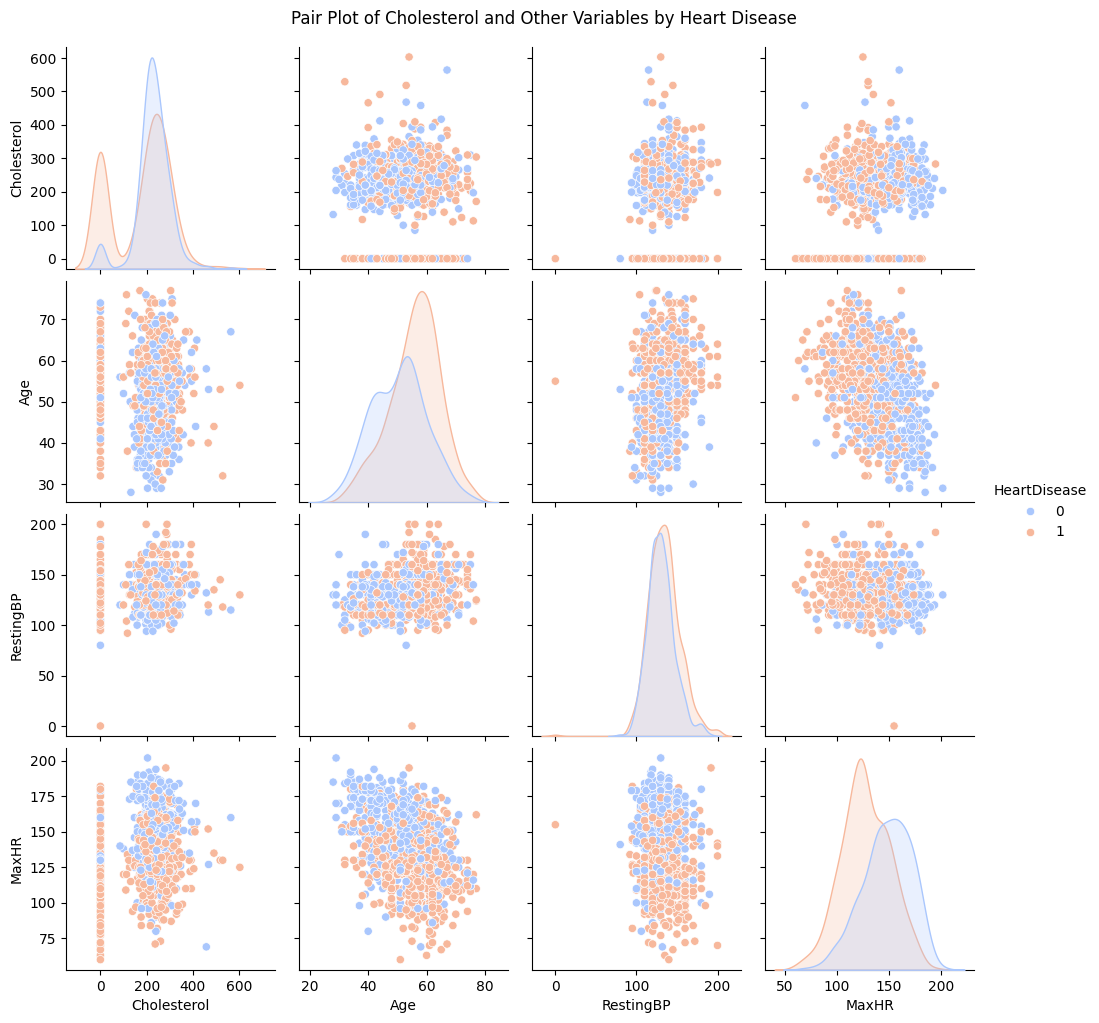

In [17]:
### Creating a pair plot of cholesterol and other variables by heart disease

sns.pairplot(
    data,
    vars=['Cholesterol', 'Age', 'RestingBP', 'MaxHR'],
    hue='HeartDisease',
    palette='coolwarm',
    diag_kind='kde'
)
plt.suptitle('Pair Plot of Cholesterol and Other Variables by Heart Disease', y=1.02)
plt.show()

/var/folders/fg/6c6fbnns7txcs5w_b8qr1wvm0000gn/T/ipykernel_3081/3882694340.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='HeartDisease', y='Cholesterol', data=data, palette='coolwarm')


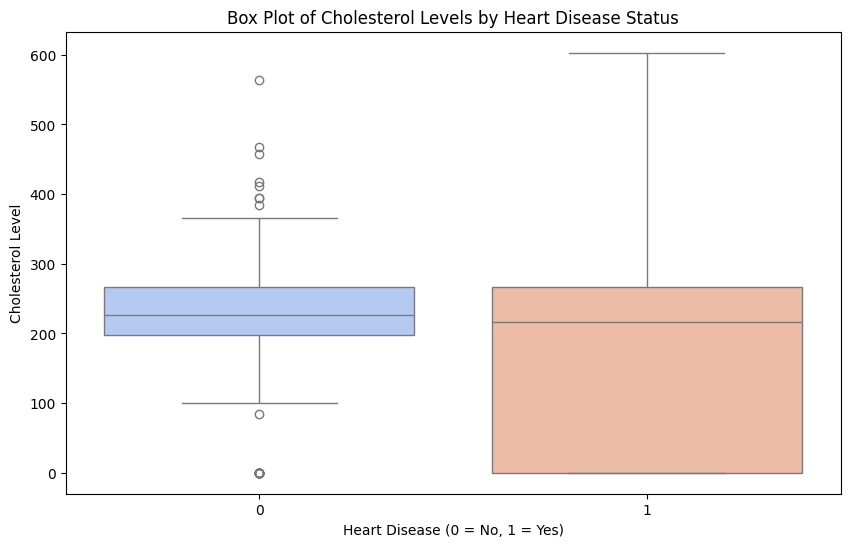

In [18]:
### Creating a box plot of cholesterol levels by heart disease status

plt.figure(figsize=(10, 6))
sns.boxplot(x='HeartDisease', y='Cholesterol', data=data, palette='coolwarm')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Cholesterol Level')
plt.title('Box Plot of Cholesterol Levels by Heart Disease Status')
plt.show()

/var/folders/fg/6c6fbnns7txcs5w_b8qr1wvm0000gn/T/ipykernel_3081/110142264.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='HeartDisease', y='Cholesterol', data=data, palette='coolwarm', bw=0.2)
/var/folders/fg/6c6fbnns7txcs5w_b8qr1wvm0000gn/T/ipykernel_3081/110142264.py:4: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(x='HeartDisease', y='Cholesterol', data=data, palette='coolwarm', bw=0.2)


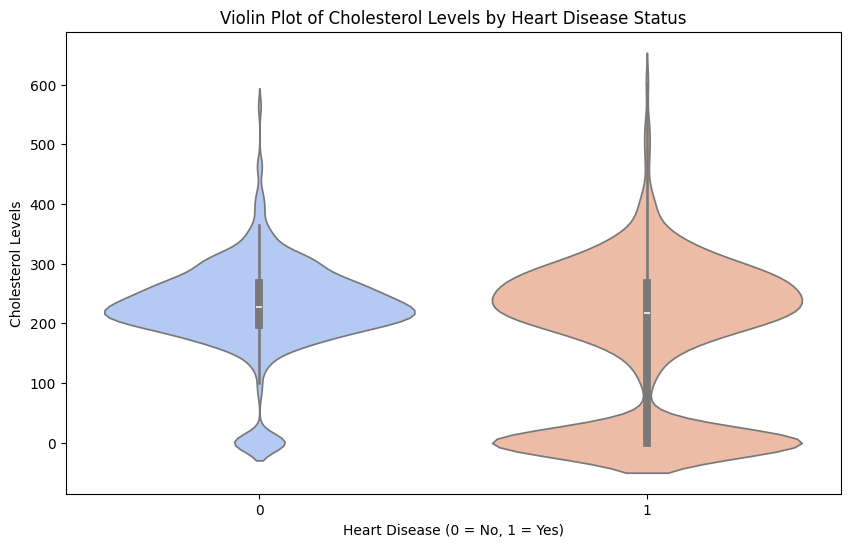

In [19]:
### Creating a violin plot of cholesterol levels by heart disease status

plt.figure(figsize=(10, 6))
sns.violinplot(x='HeartDisease', y='Cholesterol', data=data, palette='coolwarm', bw=0.2)
plt.title('Violin Plot of Cholesterol Levels by Heart Disease Status')
plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.ylabel('Cholesterol Levels')
plt.show()